In [1]:
from segment_anything import sam_model_registry
from segment_anything import SamAutomaticMaskGenerator, SamPredictor
# load default model
device = "cuda"
sam = sam_model_registry["vit_h"](checkpoint="./checkpoint/sam_vit_h_4b8939.pth")
sam.to(device=device)
mask_generator = SamPredictor(sam)

In [16]:
import nibabel as nib
import numpy as np
import torchvision.transforms as transforms
import matplotlib.pyplot as plt

def Dice(SAM_mask,i_gt_mask):
    output_mat = SAM_mask * i_gt_mask
    overlap = np.sum(output_mat)
    return 2* overlap / (np.sum(SAM_mask)+np.sum(i_gt_mask))

def mDice(image,Ground_truth_mask,predictor,prompt = "box"):
    Dice_lst = []
    local_gt = Ground_truth_mask.astype("uint8")
    if np.max(local_gt) == 0:
        return 1
    for i in range(1,np.max(local_gt)+1):
        i_gt_mask = np.where(local_gt == i, 1, 0)
        if np.sum(i_gt_mask.flatten()) == 0:
            continue
        else:
            predictor.set_image(image)
            if prompt == "point":
                # 随机选一个点
                indices = np.nonzero(i_gt_mask)
                random_index = np.random.randint(0,len(indices[0])-1)
                point = np.array([(indices[1][random_index],indices[0][random_index])])
                SAM_mask , scores, logits = predictor.predict(point_coords=point,point_labels=np.array([1]),multimask_output=False,)

                # visualization
                fig, ax = plt.subplots(1,1)
                plt.imshow(image)
                show_mask(SAM_mask,ax=ax)
                show_points(coords=points,labels=np.ones(len(points)),ax=ax)
                plt.title(f" Score: {scores[0]:.3f}", fontsize=18)
                plt.show()
            elif prompt == "points":
                # 随机选5个点
                indices = np.nonzero(i_gt_mask)
                random_index = np.random.random_integers(0,len(indices[0])-1,5)
                points = []
                for j in range(len(random_index)):
                    points.append((indices[1][random_index[j]],indices[0][random_index[j]]))
                points = np.array(points)
                SAM_mask , scores, logits = predictor.predict(point_coords=points,point_labels=np.ones(len(points)),multimask_output=False,)

                # visualization
                fig, ax = plt.subplots(1,1)
                plt.imshow(image)
                show_mask(SAM_mask,ax=ax)
                show_points(coords=points,labels=np.ones(len(points)),ax=ax)
                plt.title(f" Score: {scores[0]:.3f}", fontsize=18)
                plt.show()
            elif prompt == "box":
                indices = np.nonzero(i_gt_mask)
                x_min = min(indices[1])
                x_max = max(indices[1])
                y_min = min(indices[0])
                y_max = max(indices[0])
                input_box = np.array([x_min,y_min,x_max,y_max])
                SAM_mask , scores, logits = predictor.predict(point_coords=None,point_labels=None,box=input_box,multimask_output=False,)
                
                # visualization
                fig, ax = plt.subplots(1,1)
                plt.imshow(image)
                show_mask(SAM_mask,ax=ax)
                show_box(input_box, ax)
                plt.title(f" Score: {scores[0]:.3f}", fontsize=18)
                plt.show()
            else:
                raise NameError("prompt should be in [\"point\",\"points\",\"box\"]")
            Dice_lst.append(Dice(SAM_mask,i_gt_mask))        
    return sum(Dice_lst) / len(Dice_lst)

def show_anns(anns):
    if len(anns) == 0:
        return
    sorted_anns = sorted(anns, key=(lambda x: x['area']), reverse=True)
    ax = plt.gca()
    ax.set_autoscale_on(False)

    img = np.ones((sorted_anns[0]['segmentation'].shape[0], sorted_anns[0]['segmentation'].shape[1], 4))
    img[:,:,3] = 0
    for ann in sorted_anns:
        m = ann['segmentation']
        color_mask = np.concatenate([np.random.random(3), [0.35]])
        img[m] = color_mask
    ax.imshow(img)

def actual_mask(masks):
    act_masks = []
    for mask in masks:
        if mask["area"] >= 500 and mask["area"] <= 100000:
        # 选出大小比较正常的图像
            act_masks.append(mask)
    return act_masks

def Gray2RGB(image):
    input_img = np.zeros((image.shape[0],image.shape[1],3))
    input_img[:,:,0] =     input_img[:,:,1] =     input_img[:,:,2] =(image-np.min(image))/(np.max(image))*255
    #input_img[:,:,3] = np.ones((test_img.shape[0],test_img.shape[1]))
    input_img = input_img.astype("uint8")
    return input_img

def show_mask(mask, ax, random_color=False):
    if random_color:
        color = np.concatenate([np.random.random(3), np.array([0.6])], axis=0)
    else:
        color = np.array([30/255, 144/255, 255/255, 0.6])
    h, w = mask.shape[-2:]
    mask_image = mask.reshape(h, w, 1) * color.reshape(1, 1, -1)
    ax.imshow(mask_image)

def show_points(coords, labels, ax, marker_size=375):
    pos_points = coords[labels==1]
    neg_points = coords[labels==0]
    ax.scatter(pos_points[:, 0], pos_points[:, 1], color='green', marker='*', s=marker_size, edgecolor='white', linewidth=1.25)
    ax.scatter(neg_points[:, 0], neg_points[:, 1], color='red', marker='*', s=marker_size, edgecolor='white', linewidth=1.25)   
    
def show_box(box, ax):
    x0, y0 = box[0], box[1]
    w, h = box[2] - box[0], box[3] - box[1]
    ax.add_patch(plt.Rectangle((x0, y0), w, h, edgecolor='green', facecolor=(0,0,0,0), lw=2))    

1th data loading finished!
no ground truth segment available!(1,0)
no ground truth segment available!(1,1)
no ground truth segment available!(1,2)
no ground truth segment available!(1,3)
no ground truth segment available!(1,4)
no ground truth segment available!(1,5)
no ground truth segment available!(1,6)
no ground truth segment available!(1,7)
no ground truth segment available!(1,8)
no ground truth segment available!(1,9)
no ground truth segment available!(1,10)
no ground truth segment available!(1,11)
no ground truth segment available!(1,12)
no ground truth segment available!(1,13)
no ground truth segment available!(1,14)
no ground truth segment available!(1,15)
no ground truth segment available!(1,16)
no ground truth segment available!(1,17)
no ground truth segment available!(1,18)
no ground truth segment available!(1,19)
no ground truth segment available!(1,20)
no ground truth segment available!(1,21)
no ground truth segment available!(1,22)
no ground truth segment available!(1,23)

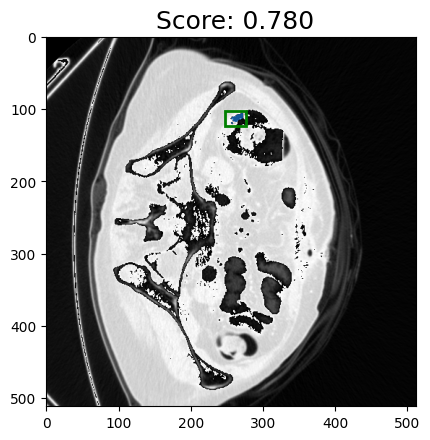

mDice value for 1,61 is 0.5175600739371534


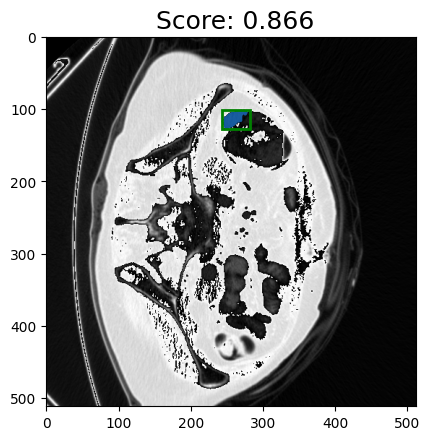

mDice value for 1,62 is 0.8546184738955823


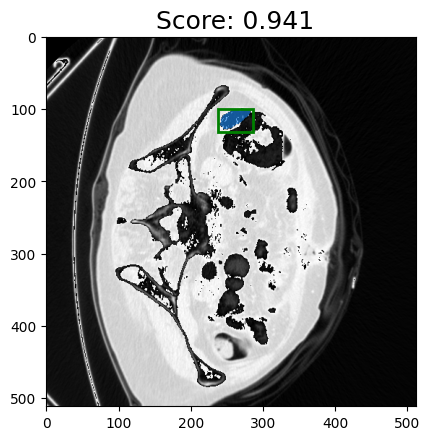

mDice value for 1,63 is 0.8356702187324734


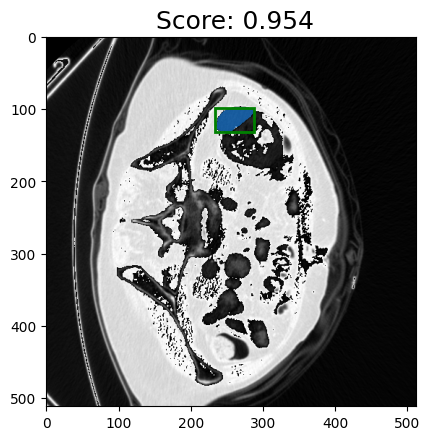

mDice value for 1,64 is 0.9452815226011102


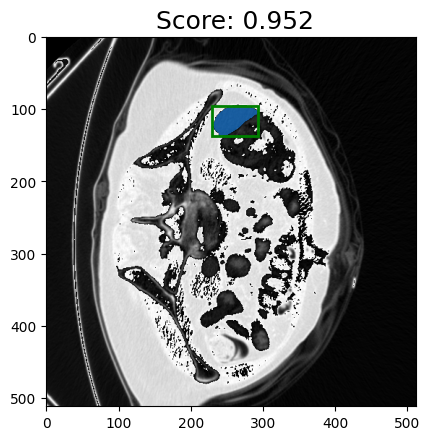

mDice value for 1,65 is 0.9392427355444672


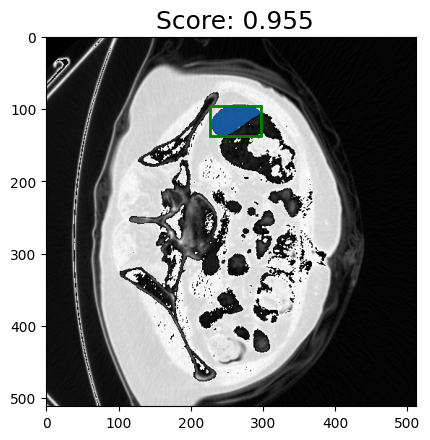

mDice value for 1,66 is 0.950920245398773


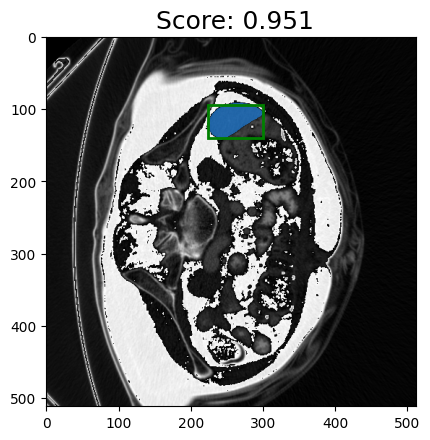

mDice value for 1,67 is 0.9585079631181894


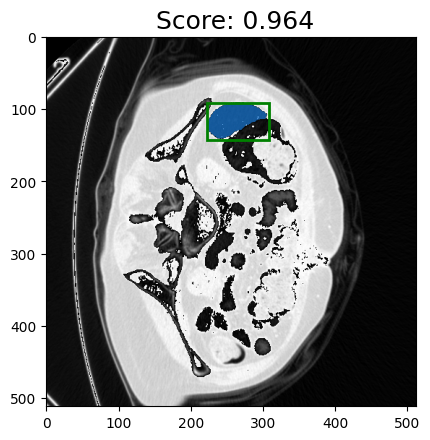

mDice value for 1,68 is 0.9507224898110411


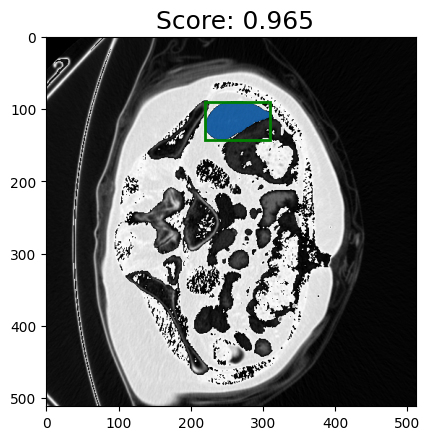

mDice value for 1,69 is 0.9763578274760384


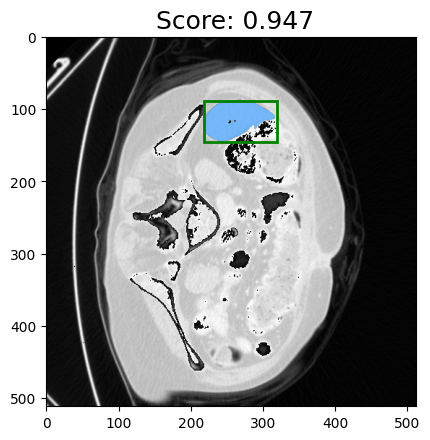

mDice value for 1,70 is 0.9657056974996584


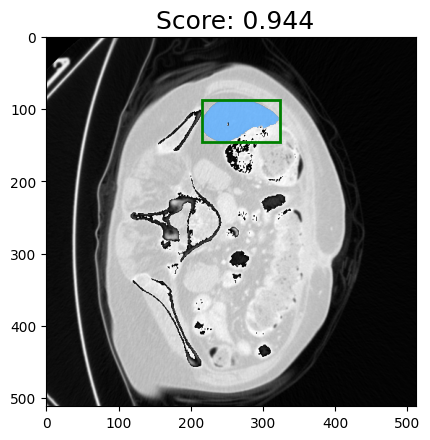

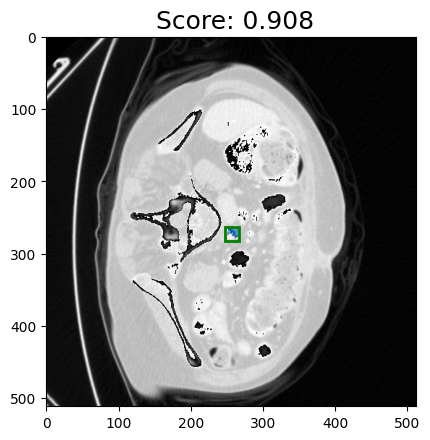

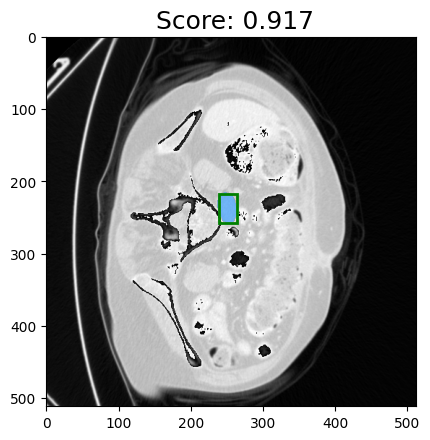

mDice value for 1,71 is 0.8570848587250283


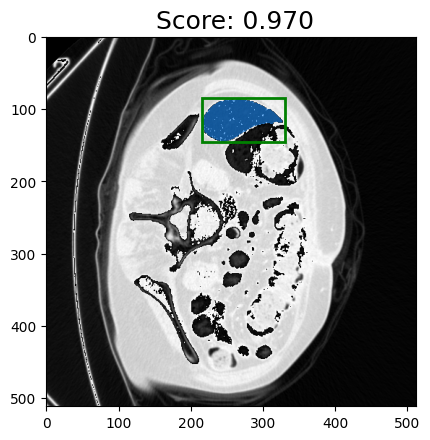

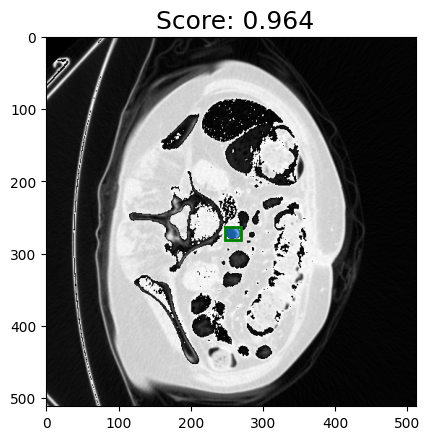

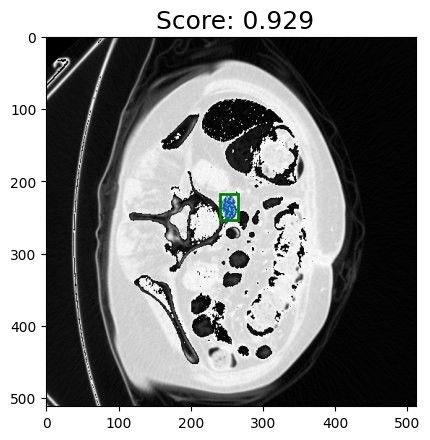

mDice value for 1,72 is 0.8851042140385862


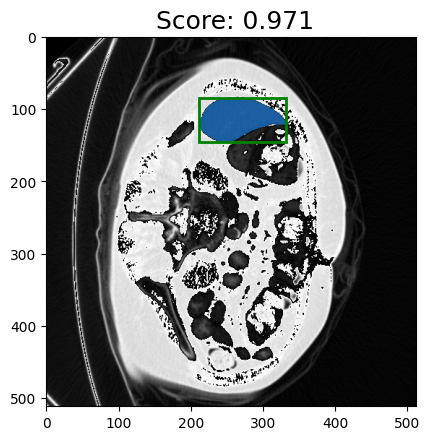

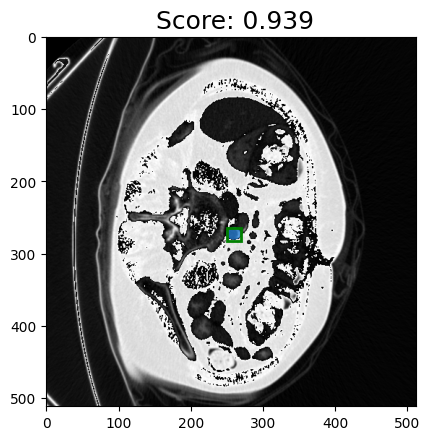

KeyboardInterrupt: 

In [17]:
import json
from PIL import Image
import cv2
from pycocotools import mask as mask_utils

with open("./data/dataset_0.json") as file1:
    dataset = json.load(file1)
# test = dataset["test"]
# we cant use test data
training = dataset["training"]
validation = dataset["validation"]

# Task 1:
# load imgs and labels
i = 0
for data in training:
    i+= 1
    img_path, label_path = data["image"], data["label"]
    image = nib.load(img_path)
    label = nib.load(label_path)
    image_img_data = image.get_fdata()
    label_img_data = label.get_fdata()
    num_slice = label.shape[-1]
    print(f"{i}th data loading finished!")
    for j in range(num_slice):
        ground_truth = label_img_data[:,:,j]
        input_img = image_img_data[:,:,j]
        input_img = Gray2RGB(input_img)
        SAM_mDice = mDice(input_img,ground_truth,mask_generator)
        if SAM_mDice == 1:
            print(f"no ground truth segment available!({i},{j})")
        else:
            print(f"mDice value for {i},{j} is {SAM_mDice}")
    if i >= 1:
        break

        